In [5]:
import os
import caer
import canaro
import cv2 as cv
import numpy as np
import gc #garbage collection
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten
from keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import LearningRateScheduler

In [6]:
#model expects all the data to be of same size hence we resize the data into same size
IMG_SIZE = (80,80)
channel =1
char_path=r'C:/Users/sadik/OneDrive/Desktop/OpenCV/simpsons_dataset'

In [7]:
#Creating a character dictionary,sorting it in descending order--> kati ota folder cha in dataset and kati img cha in each folder
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))
    
# Sort in descending order
char_dict= caer.sort_dict(char_dict,descending=True)
char_dict
#print (char_dict)

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [8]:
#Getting the first 10 categories with the most number of images
characters=[]
count = 0
for i in char_dict:
    characters.append(i[0])
    count +=1
    if count >= 10:
        break
characters
#print(characters)

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [9]:
#Creating the training data this will go see every folcder under dataset and look for every elements inside the character
train= caer.preprocess_from_dir(char_path,characters,channels=channel, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.006998538970947266s
[INFO] At 1000 files
[INFO] 1454 files found in 0.004416227340698242s
[INFO] At 1000 files
[INFO] 1452 files found in 0.0032503604888916016s
[INFO] At 1000 files
[INFO] 1354 files found in 0.003000974655151367s
[INFO] At 1000 files
[INFO] 1342 files found in 0.0046613216400146484s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0032203197479248047s
[INFO] At 1000 files
[INFO] 1206 files found in 0.002981424331665039s
[INFO] At 1000 files
[INFO] 1194 files found in 0.003192901611328125s
[INFO] At 1000 files
[INFO] 1193 files found in 0.003998756408691406s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0030059814453125s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 17s


In [10]:
#Number of training samples
len(train)

13811

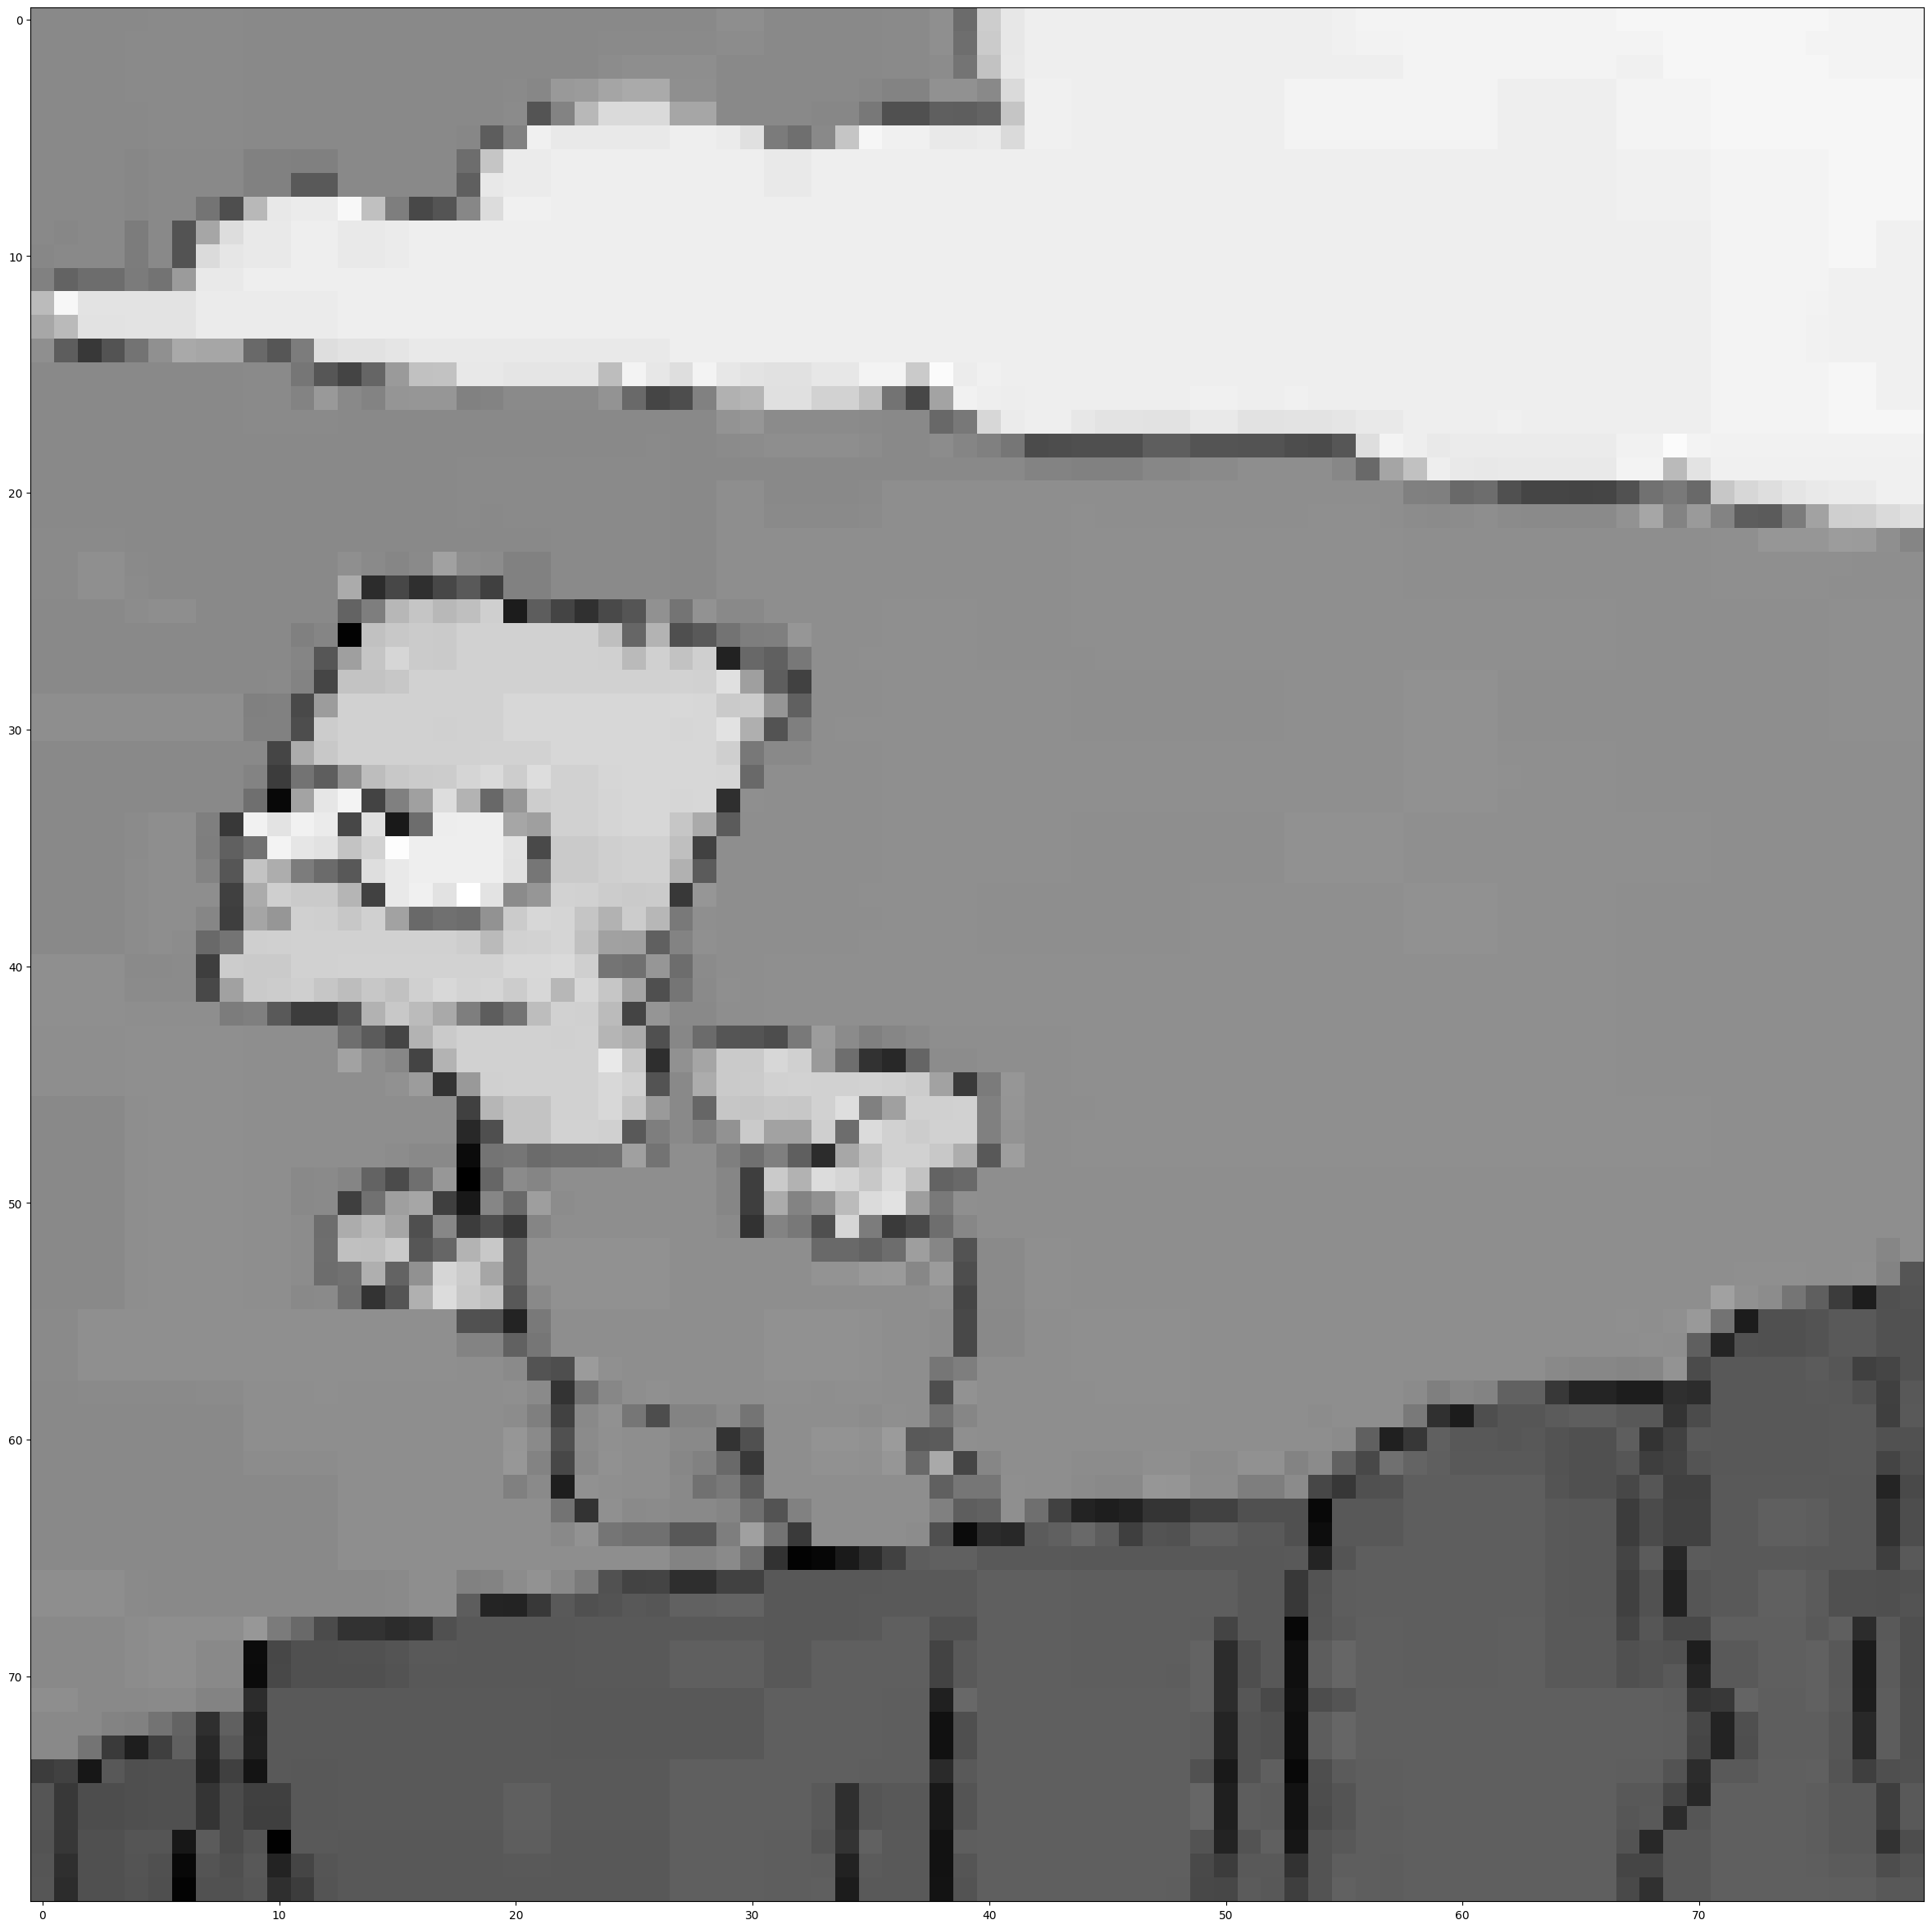

In [11]:
#Visulaizing the data (OpenCv doesnt display well in Jupyter notebooks)
plt.figure(figsize=(30,30))
plt.imshow(train[1][0],cmap='gray') #train[0] accesses the first element in the train list, which might be a tuple where the first element is the image data.and train[0][0] accesses the first element of that tuple, which should be the actual image array.
plt.show()

In [12]:
#Separating the array and corresponding labels
featureSet,labels= caer.sep_train(train,IMG_SIZE=IMG_SIZE)

In [13]:
#Normalize the featureSet ==>(0,1)
featureSet=caer.normalize(featureSet)

In [14]:
#Converting numerical labels to binary class vectors
labels=to_categorical(labels,len(characters))

In [15]:
# Creating train and validatiob data
x_train,x_val,y_train,y_val= caer.train_val_split(featureSet,labels,val_ratio=.2)

In [16]:
#Deleting variables to save memory
del train
del featureSet
del labels
gc.collect()

0

In [17]:
# Useful variables when training
BATCH_SIZE=32
EPOCHS=10

In [18]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen=canaro.generators.imageDataGenerator()
train_gen=datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [19]:
def createSimpsonsModel(IMG_SIZE, channels, output_dim, loss, decay, learning_rate, momentum, nesterov):
    model = Sequential()
    
    # Input Layer
    model.add(Conv2D(32, (3, 3), input_shape=(*IMG_SIZE, channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Hidden Layers
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    # Output Layer
    model.add(Dense(output_dim, activation='softmax'))
    
    optimizer = SGD(learning_rate=learning_rate, decay=decay, momentum=momentum, nesterov=nesterov)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [20]:
# Create our model (returns the compiled model)
model=canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE,
                                        channels=channel,
                                        output_dim=len(characters),
                                        loss='binary_crossentropy',
                                        decay=1e-7,
                                        learning_rate=0.001,
                                        momentum=0.9,
                                        nesterov=True)

#model.summary()

c:\Users\sadik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\sadik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:

#Training the model 
callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]
training=model.fit(train_gen,steps_per_epoch=len(x_train)//BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val,y_val),validation_steps=len(y_val)//BATCH_SIZE,callbacks=callbacks_list)
print(characters)

Epoch 1/10


c:\Users\sadik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.1432 - loss: 0.3769 - val_accuracy: 0.1614 - val_loss: 0.3339 - learning_rate: 0.0100
Epoch 2/10


c:\Users\sadik\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0938 - loss: 0.3231 - val_accuracy: 0.1614 - val_loss: 0.3337 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 147s 426ms/step - accuracy: 0.1589 - loss: 0.3239 - val_accuracy: 0.1614 - val_loss: 0.3332 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.0938 - loss: 0.3250 - val_accuracy: 0.1614 - val_loss: 0.3333 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 167s 484ms/step - accuracy: 0.1600 - loss: 0.3233 - val_accuracy: 0.1614 - val_loss: 0.3346 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1250 - loss: 0.3259 - val_accuracy: 0.1614 - val_loss: 0.3348 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 162s 467ms/step - accuracy: 0.1665 - loss: 0.3213 - val_accuracy: 0.2341 - val_loss: 0.3235 - learning_rate: 0.0100
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1875 - loss: 0

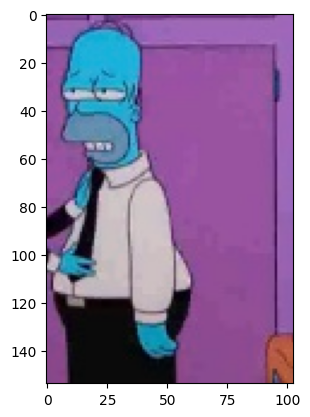

In [26]:
#Testing
test_path= r'C:/Users/sadik/OneDrive/Desktop/OpenCV/kaggle_simpson_testset/kaggle_simpson_testset/homer_simpson_36.jpg'
img=cv.imread(test_path)
plt.imshow(img)
plt.show()

In [27]:
def prepare(image):
    image=cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    image=cv.resize(image,IMG_SIZE)
    image=caer.reshape(image,IMG_SIZE,1)
    return image

In [28]:
prediction= model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [29]:
# Getting class with the highesh probability
print(characters[np.argmax(prediction[0])])


homer_simpson
